# Train Task2Baseline model

This is PyTorch version trainer code, will basically do the same with the original baseline written with Keras.

- Train with all machine type data, then save each models.
- Tensorboard visualization will show you training trajectories, thanks to [PyTorch Lightning](https://github.com/PyTorchLightning/pytorch-lightning).
- And some extra visualizations.

In [7]:
from dlcliche.notebook import *
from dlcliche.utils import (
    sys, random, Path, np, plt,
    ensure_folder, deterministic_everything,
)

import torch
import pytorch_lightning as pl

sys.path.append('..')
import common as com

from pytorch_model import Task2Baseline

param = com.yaml_load('config.yaml')
ensure_folder(param['model_directory'])

deterministic_everything(2020, pytorch=True)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

dirs = com.select_dirs(param=param, mode='development')

2020-03-10 15:41:18,652 - INFO - load_directory <- development


In [2]:
class Task2Dataset(torch.utils.data.Dataset):
    def __init__(self, files, n_mels, frames, n_fft, hop_length, power, transform, cache_to=None):
        self.transform = transform
        self.files = files
        self.n_mels, self.frames, self.n_fft = n_mels, frames, n_fft
        self.hop_length, self.power = hop_length, power
        # load cache or convert all the data for the first time
        if cache_to is not None and Path(cache_to).exists():
            com.logger.info(f'Loading cached {cache_to}')
            self.X = np.load(cache_to)
        else:
            self.X = com.list_to_vector_array(self.files,
                             n_mels=self.n_mels,
                             frames=self.frames,
                             n_fft=self.n_fft,
                             hop_length=self.hop_length,
                             power=self.power)
            if cache_to is not None:
                np.save(cache_to, self.X)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, index):
        x = self.X[index]
        x = self.transform(x)
        return x, x

In [3]:
%load_ext tensorboard
%tensorboard --logdir lightning_logs/

Reusing TensorBoard on port 6006 (pid 2405), started 19:58:28 ago. (Use '!kill 2405' to kill it.)

In [ ]:
class Task2(pl.LightningModule):

    def __init__(self, hparams, files):
        super().__init__()
        self.model = Task2Baseline()
        self.mseloss = torch.nn.MSELoss()
        self.hparams = hparams
        # split data files
        n_val = int(hparams.validation_split * len(files))
        self.val_files = random.sample(files, n_val)
        self.train_files = [f for f in files if f not in self.val_files]

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_nb):
        x, y = batch
        y_hat = self.forward(x)
        loss = self.mseloss(y_hat, y)
        tensorboard_logs = {'train_loss': loss}
        return {'loss': loss, 'log': tensorboard_logs}

    def validation_step(self, batch, batch_nb):
        x, y = batch
        y_hat = self.forward(x)
        return {'val_loss': self.mseloss(y_hat, y)}

    def validation_epoch_end(self, outputs):
        avg_loss = torch.stack([x['val_loss'] for x in outputs]).mean()
        tensorboard_logs = {'val_loss': avg_loss}
        return {'avg_val_loss': avg_loss, 'log': tensorboard_logs}

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.hparams.lr,
                                betas=(self.hparams.b1, self.hparams.b2),
                                weight_decay=self.hparams.weight_decay)

    def _get_dl(self, for_what):
        files = self.train_files if for_what == 'train' else self.val_files
        cache_file = f'{self.hparams.work_folder}/__cache_{str(files[0]).split("/")[-3]}_{for_what}.npy'
        ds = Task2Dataset(files,
                           n_mels=self.hparams.n_mels,
                           frames=self.hparams.frames,
                           n_fft=self.hparams.n_fft,
                           hop_length=self.hparams.hop_length,
                           power=self.hparams.power,
                           transform=com.ToTensor1d(device=device),
                           cache_to=cache_file)
        return torch.utils.data.DataLoader(ds, batch_size=self.hparams.batch_size,
                          shuffle=(self.hparams.shuffle if for_what == 'train' else False))

    def train_dataloader(self):
        return self._get_dl('train')

    def val_dataloader(self):
        return self._get_dl('val')


from argparse import Namespace

args = {
    'epochs': param['fit']['epochs'],
    'batch_size': param['fit']['batch_size'],
    'lr': 0.001,
    'b1': 0.9,
    'b2': 0.999,
    'weight_decay': 0.0,
    'shuffle': param['fit']['shuffle'],
    'n_mels': param["feature"]["n_mels"],
    'frames': param["feature"]["frames"],
    'n_fft': param["feature"]["n_fft"],
    'hop_length': param["feature"]["hop_length"],
    'power': param["feature"]["power"],
    'work_folder': param['model_directory'],
    'validation_split': param['fit']['validation_split'],
}
hparams = Namespace(**args)

for target_dir in dirs:
    target = str(target_dir).split('/')[-1]
    print(f'==== Start training [{target}] with {torch.cuda.device_count()} GPU(s). ====')

    files = com.file_list_generator(target_dir)

    task2 = Task2(hparams, files)
    trainer = pl.Trainer(max_epochs=hparams.epochs, gpus=torch.cuda.device_count())
    trainer.fit(task2)
    
    model_file = f'{param["model_directory"]}/model_{target}.pth'
    torch.save(task2.model.state_dict(), model_file)
    print(f'saved {model_file}.')

## Visualize 

In [5]:
# Get one batch of samples from validation set, then get model prediction result.
dl = task2.val_dataloader()
x, y = next(iter(dl))
with torch.no_grad():
    yhat = task2.model(x)

2020-03-10 15:41:05,546 - INFO - Loading cached ./model/__cache_ToyConveyor_val.npy


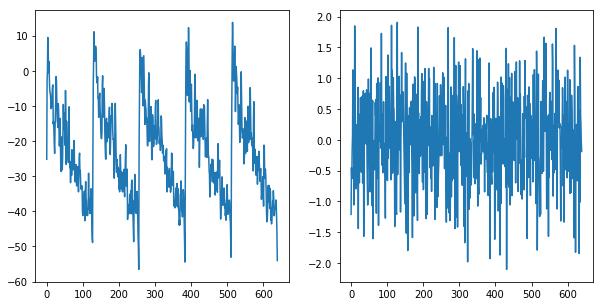

In [11]:
# Show 
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
sample_idx = 0
axs[0].plot(x.cpu().numpy()[sample_idx][0]); axs[1].plot(yhat.cpu().numpy()[sample_idx][0]);

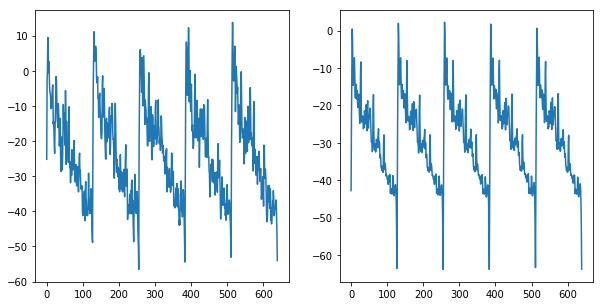

In [14]:
# If you have model weights trained with ToyCar, model will predict like this.

# uncomment if you have weights --> task2.model.load_state_dict(torch.load('model/model_ToyCar.pth'))
# with torch.no_grad():
#     yhat = task2.model(x)

fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].plot(x.cpu().numpy()[sample_idx][0]); axs[1].plot(yhat.cpu().numpy()[sample_idx][0]);

## Data structure check

Curious about data structure? here's how `file_to_vector_array()` does.

In [21]:
# simplify problem. if we use n_mels and frames as follows,
n_mels = 2
frames = 5

# and let's set wave length is short and mel spectrogram array length is,
vector_array_size = 50

# log_mel_spectrogram will be like this.
dims = frames * n_mels
tmp = np.array(list(range(vector_array_size + frames - 1)))
log_mel_spectrogram = np.c_[tmp, tmp+0.1].T
print('simply after converting wave into log mel spectrogram, log_mel_spectrogram will have shape like this:', log_mel_spectrogram.shape)
print(log_mel_spectrogram)

simply after converting wave into log mel spectrogram, log_mel_spectrogram will have shape like this: (2, 54)
[[ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.  39.  40.  41.
  42.  43.  44.  45.  46.  47.  48.  49.  50.  51.  52.  53. ]
 [ 0.1  1.1  2.1  3.1  4.1  5.1  6.1  7.1  8.1  9.1 10.1 11.1 12.1 13.1
  14.1 15.1 16.1 17.1 18.1 19.1 20.1 21.1 22.1 23.1 24.1 25.1 26.1 27.1
  28.1 29.1 30.1 31.1 32.1 33.1 34.1 35.1 36.1 37.1 38.1 39.1 40.1 41.1
  42.1 43.1 44.1 45.1 46.1 47.1 48.1 49.1 50.1 51.1 52.1 53.1]]


In [26]:
vector_array = np.zeros((vector_array_size, dims))

print(f"we'd like to arrange data structure and copy into a vector_array with shape {vector_array.shape} as follows:\n")

for t in range(frames):
    vector_array[:, n_mels * t: n_mels * (t + 1)] = log_mel_spectrogram[:, t: t + vector_array_size].T

print(vector_array)

we'd like to arrange data structure and copy into a vector_array with shape (50, 10) as follows:

[[ 0.   0.1  1.   1.1  2.   2.1  3.   3.1  4.   4.1]
 [ 1.   1.1  2.   2.1  3.   3.1  4.   4.1  5.   5.1]
 [ 2.   2.1  3.   3.1  4.   4.1  5.   5.1  6.   6.1]
 [ 3.   3.1  4.   4.1  5.   5.1  6.   6.1  7.   7.1]
 [ 4.   4.1  5.   5.1  6.   6.1  7.   7.1  8.   8.1]
 [ 5.   5.1  6.   6.1  7.   7.1  8.   8.1  9.   9.1]
 [ 6.   6.1  7.   7.1  8.   8.1  9.   9.1 10.  10.1]
 [ 7.   7.1  8.   8.1  9.   9.1 10.  10.1 11.  11.1]
 [ 8.   8.1  9.   9.1 10.  10.1 11.  11.1 12.  12.1]
 [ 9.   9.1 10.  10.1 11.  11.1 12.  12.1 13.  13.1]
 [10.  10.1 11.  11.1 12.  12.1 13.  13.1 14.  14.1]
 [11.  11.1 12.  12.1 13.  13.1 14.  14.1 15.  15.1]
 [12.  12.1 13.  13.1 14.  14.1 15.  15.1 16.  16.1]
 [13.  13.1 14.  14.1 15.  15.1 16.  16.1 17.  17.1]
 [14.  14.1 15.  15.1 16.  16.1 17.  17.1 18.  18.1]
 [15.  15.1 16.  16.1 17.  17.1 18.  18.1 19.  19.1]
 [16.  16.1 17.  17.1 18.  18.1 19.  19.1 20.  20.1]
 